
# DPS-CGK

## Data Preparation

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
from tabulate import tabulate

In [3]:
df_dps_cgk = pd.read_excel('/content/dps_cgk.xlsx', sheet_name=0, parse_dates=['Tanggal'])

In [4]:
df_dps_cgk.head()

,Tanggal,Harga
0,2022-07-20,1340006.0
1,2022-07-21,1326606.0
2,2022-07-22,1326606.0
3,2022-07-23,1326606.0
4,2022-07-24,1392540.0


In [5]:
df_dps_cgk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Tanggal  119 non-null    datetime64[ns]
 1   Harga    119 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.0 KB


In [6]:
df_dps_cgk.set_index('Tanggal', inplace=True)
df_dps_cgk.tail(100)

,Harga
Tanggal,
2022-08-08,1285220.0
2022-08-09,1288576.0
2022-08-10,1288576.0
2022-08-11,1393419.0
2022-08-12,1393419.0
...,...
2022-11-11,1464900.0
2022-11-12,1466442.0
2022-11-13,1466442.0


## EDA

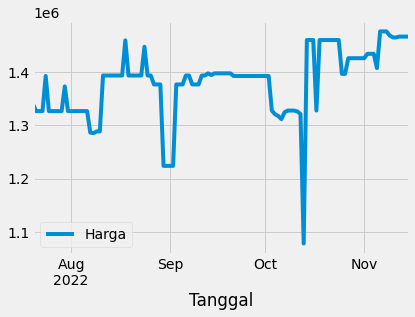

In [ ]:
df_dps_cgk.plot(kind='line')
plt.show()

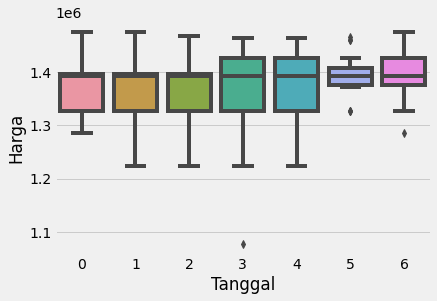

In [ ]:
sns.boxplot(x=df_dps_cgk.index.dayofweek, y=df_dps_cgk['Harga'])
plt.show()

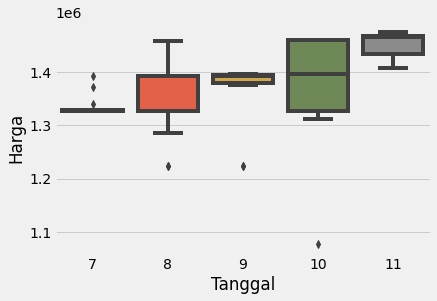

In [ ]:
sns.boxplot(x=df_dps_cgk.index.month, y=df_dps_cgk['Harga'])
plt.show()

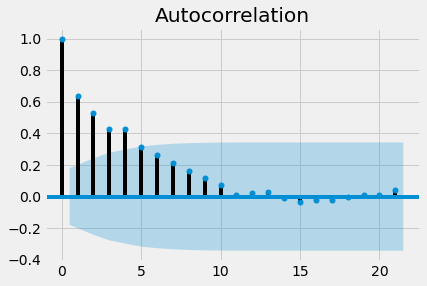

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

plot_acf(df_dps_cgk['Harga'])
plt.show()

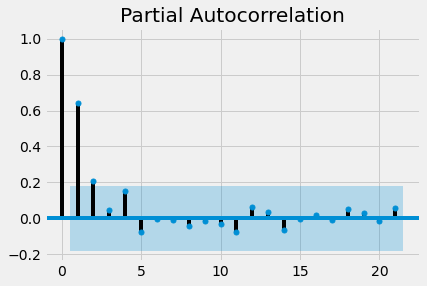

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_dps_cgk['Harga'], method='ywm')
plt.show()

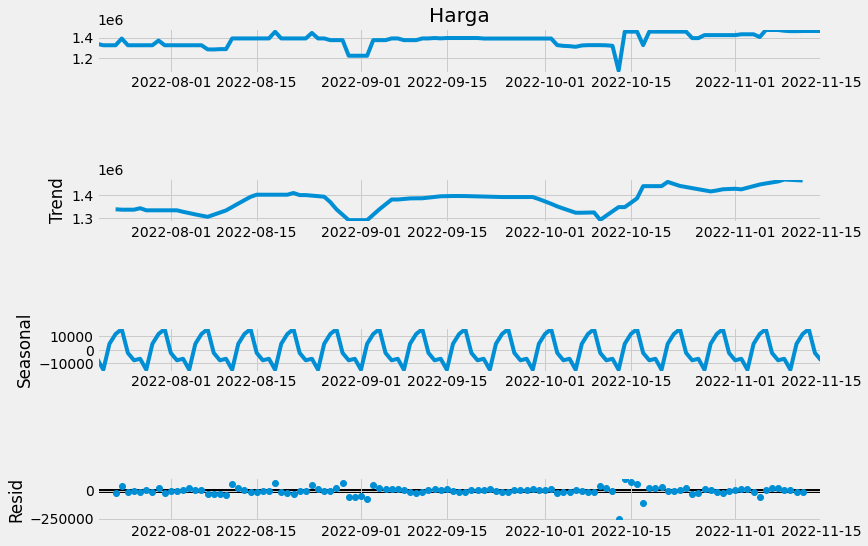

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_dps_cgk['Harga'])
fig = result.plot()
fig.set_size_inches((16, 9))
plt.show()

ide: ambil semua lag yg autocorr nya diluar biru, buatnya bukan lag2=lag2 aja, tapi lag2= lag1,lag2 dst untuk lag lainnya. Ini lebih make sense daripada ambil satu lag aja tiap nyoba.
link buat belajar parameter:
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/?
atau ga cari yg lain gpp, mgt guys maap aku ngaret terus <3

## Tuning Model yeah

In [7]:
#build lags
def create_features(df,n_lag,label=None):
    """
    Creates time series features from datetime index
    """
    df['lag'] = df['Harga'].shift(n_lag)
    
    X = df[['lag']]
    if label:
        y = df[label]
        return X, y
    return X

In [8]:
from datetime import timedelta, datetime
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
df_dps_cgk.head(50)

,Harga
Tanggal,
2022-07-20,1340006.0
2022-07-21,1326606.0
2022-07-22,1326606.0
2022-07-23,1326606.0
2022-07-24,1392540.0
2022-07-25,1326606.0
2022-07-26,1326606.0
2022-07-27,1326606.0
2022-07-28,1326606.0


In [ ]:
#tuning train test split
def cross_validation(data,n_lags,n_splits=10,n_iter=10):
  s= datetime(2022,7,20)  #hari pertama data diambil
  t = datetime(2022,9,27)  #100 hari terakhir
  days_until_depart=50
  rmse_split_mean=[]
  rmse_total_split=[]
  print('=== CROSS VALIDATE LAGS {} START ==='.format(n_lags))
  for i in range(0,days_until_depart,n_splits):
    split_date = t
    s_train = data.loc[s+timedelta(days=n_lags)<data.index].copy()
    train = s_train.loc[s_train.index <= split_date].copy()
    test = data.loc[data.index >= split_date].copy()
    X_train, y_train = create_features(train,n_lags,label='Harga')
    X_test, y_test = create_features(test,n_lags,label='Harga')
    split=50
    tscv = TimeSeriesSplit(n_splits=split)
    rmse=[]
    param=[]
    for j in range(n_iter):
      reg = xgb.XGBRegressor()
      reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=0)
      y_pred=reg.predict(X_test)
      rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    rmse_total_split.append(rmse)
    rmse_split_mean.append(np.mean(rmse))
    t = t - timedelta(days=10)
  rmse_total_split = np.array( rmse_total_split)
  print('Lags {0} RMSE: {1}\n'.format(n_lags, rmse_split_mean))
  return rmse_total_split, rmse_split_mean

In [ ]:
rmse_lags1, rmse_lags1_mean = cross_validation(df_dps_cgk, n_lags=1)

=== CROSS VALIDATE LAGS 1 START ===
[04:05:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:05:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:05:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:05:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:05:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:05:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:05:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:05:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:lin

In [ ]:
print('Lags 1 RMSE Mean:', np.mean(rmse_lags1_mean))

Lags 1 RMSE Mean: 64052.78881808283


In [ ]:
rmse_lags1.mean(axis=1)

array([68726.98820804, 67896.32782326, 63151.25971977, 60978.6186247 ,
       59510.74971463])

## Tuning Lagi

Ambil lag= 1 dan test=80, karena mean RMSE nya paling rendah

In [ ]:
df_dps_cgk.head(50)

,Harga
Tanggal,
2022-07-20,1340006.0
2022-07-21,1326606.0
2022-07-22,1326606.0
2022-07-23,1326606.0
2022-07-24,1392540.0
2022-07-25,1326606.0
2022-07-26,1326606.0
2022-07-27,1326606.0
2022-07-28,1326606.0


In [ ]:
df_dps_cgk.shape

(119, 1)

In [9]:
s= datetime(2022,7,20)
t=datetime(2022,9,27)
e= datetime(2022, 11, 15)
split_date = t
s_train = df_dps_cgk.loc[s+timedelta(days=1) < df_dps_cgk.index].copy()
train = s_train.loc[s_train.index <= split_date].copy()
test = df_dps_cgk.loc[df_dps_cgk.index >= split_date].copy()
X_train, y_train = create_features(train,1,label='Harga')
X_test, y_test = create_features(test,1,label='Harga')

In [ ]:
y_test.shape

(50,)

In [ ]:
y_train.shape

(68,)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=50)
rmse=[]
param_tun=[]
for i in range(10):
  params = {'max_depth': [3, 5, 6, 7, 8, 9, 10],
            'min_child_weight':[6, 5, 4, 3, 2],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 0.75, 1.0),            #Typical values: 0.5-1
           'colsample_bytree': np.arange(0.5, 0.75, 1.0),     #Typical values: 0.5-1
           'colsample_bylevel': np.arange(0.5, 0.75, 1.0),    #Typical values: 0.5-1
           'eta':[0.01, 0.015, 0.05, 0.075, 0.1, 0.15, 0.2],           #Typical final values to be used: 0.01-0.2  
           'lambda':[0.00001, 0.0001, 0.001, 0.01, 0.05],              #L2 regularization, (0,0.1)
           'gamma':[0.01, 0.015, 0.05, 0.075, 0.1, 0.15, 0.2],        #Typical final values to be used: 0.01-0.2 
           'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.05],              #L1 regularization, (0,0.1)
           'n_estimators': [100, 500, 1000]}
  xgbr = xgb.XGBRegressor(seed = 20)
  clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=100,cv=tscv,
                         verbose=1)
  clf.fit(X_train,y_train)
  rmse.append((-clf.best_score_)**(1/2.0))
  param_tun.append(clf.best_params_)

Streaming output truncated to the last 5000 lines.
[04:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:41:59] WARNING: /workspace/src/objective/regression_obj.

In [ ]:
print('Nilai RMSE Maksimal=',np.max(rmse))
print('Nilai RMSE Minimal=',np.min(rmse))
print('Nilai Rata-rata RMSE=',np.mean(rmse))
print('Nilai Median RMSE=',np.median(rmse))
print('Parameter untuk RMSE Minimal:',param_tun[rmse.index(np.min(rmse))])

Nilai RMSE Maksimal= 42006.20065945622
Nilai RMSE Minimal= 41559.41197710965
Nilai Rata-rata RMSE= 41639.66033636759
Nilai Median RMSE= 41606.57466649515
Parameter untuk RMSE Minimal: {'subsample': 0.5, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 9, 'learning_rate': 0.3, 'lambda': 0.0001, 'gamma': 0.2, 'eta': 0.15, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'alpha': 0.01}


## Prediction

subsample': 0.5, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 9, 'learning_rate': 0.3, 'lambda': 0.0001, 'gamma': 0.2, 'eta': 0.15, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'alpha': 0.01

In [10]:
reg = xgb.XGBRegressor(subsample= 0.5,n_estimators=500,max_depth=9,min_child_weight=2, gamma=0.2,
                       learning_rate=0.3,colsample_bytree= 0.5,
                       colsample_bylevel= 0.5,reg_alpha=0.01, 
                       reg_lambda=0.0001)

forecast=reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

[08:39:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [11]:
test['Test_Prediksi'] = reg.predict(X_test)
all = pd.concat([test, train], sort=False)

In [12]:
y_test

Tanggal
2022-09-27    1392494.0
2022-09-28    1392494.0
2022-09-29    1392494.0
2022-09-30    1392494.0
2022-10-01    1392494.0
2022-10-02    1392494.0
2022-10-03    1327600.0
2022-10-04    1320704.0
2022-10-05    1317539.0
2022-10-06    1311476.0
2022-10-07    1324518.0
2022-10-08    1327600.0
2022-10-09    1327600.0
2022-10-10    1327600.0
2022-10-11    1326050.0
2022-10-12    1321054.0
2022-10-13    1078150.0
2022-10-14    1460000.0
2022-10-15    1460000.0
2022-10-16    1460000.0
2022-10-17    1327600.0
2022-10-18    1460000.0
2022-10-19    1460000.0
2022-10-20    1460000.0
2022-10-21    1460000.0
2022-10-22    1460000.0
2022-10-23    1460000.0
2022-10-24    1460000.0
2022-10-25    1396500.0
2022-10-26    1396500.0
2022-10-27    1425900.0
2022-10-28    1425900.0
2022-10-29    1425900.0
2022-10-30    1425900.0
2022-10-31    1425900.0
2022-11-01    1425900.0
2022-11-02    1434132.0
2022-11-03    1434132.0
2022-11-04    1434132.0
2022-11-05    1407231.0
2022-11-06    1476157.0
2022-11-

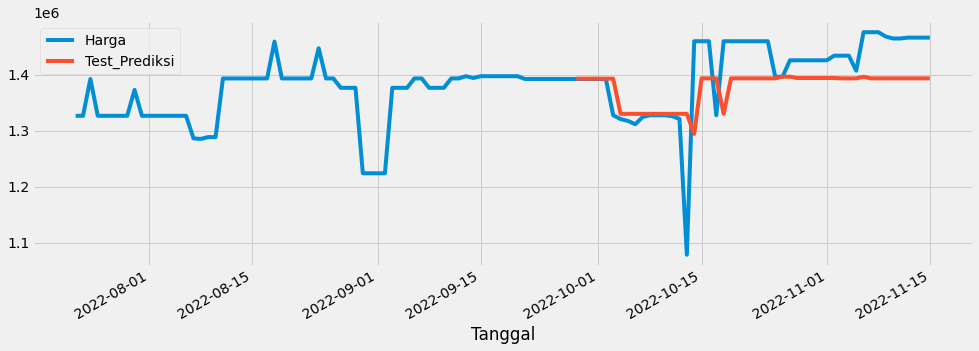

In [13]:
_ = all[['Harga','Test_Prediksi']].plot(figsize=(15, 5))

In [14]:
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

In [15]:
X_test

,lag
Tanggal,
2022-09-27,NaN
2022-09-28,1392494.0
2022-09-29,1392494.0
2022-09-30,1392494.0
2022-10-01,1392494.0
2022-10-02,1392494.0
2022-10-03,1392494.0
2022-10-04,1327600.0
2022-10-05,1320704.0


In [16]:
df_dps_cgk2 = df_dps_cgk.copy()
df_dps_cgk2['Prediksi'] = 0

df_dps_cgk2.tail(100)

,Harga,Prediksi
Tanggal,,
2022-08-08,1285220.0,0
2022-08-09,1288576.0,0
2022-08-10,1288576.0,0
2022-08-11,1393419.0,0
2022-08-12,1393419.0,0
...,...,...
2022-11-11,1464900.0,0
2022-11-12,1466442.0,0
2022-11-13,1466442.0,0


In [17]:
y_test_pred.shape

(50,)

In [18]:
df_dps_cgk2.iloc[:1, 1] = np.nan
df_dps_cgk2 .iloc[1:-50, 1] = y_train_pred
df_dps_cgk2 

,Harga,Prediksi
Tanggal,,
2022-07-20,1340006.0,NaN
2022-07-21,1326606.0,1341933.50
2022-07-22,1326606.0,1330109.00
2022-07-23,1326606.0,1330109.00
2022-07-24,1392540.0,1329209.75
...,...,...
2022-11-11,1464900.0,0.00
2022-11-12,1466442.0,0.00
2022-11-13,1466442.0,0.00


In [19]:
df_dps_cgk2 .iloc[-50:, 1] = y_test_pred
df_dps_cgk2 

,Harga,Prediksi
Tanggal,,
2022-07-20,1340006.0,NaN
2022-07-21,1326606.0,1341933.50
2022-07-22,1326606.0,1330109.00
2022-07-23,1326606.0,1330109.00
2022-07-24,1392540.0,1329209.75
...,...,...
2022-11-11,1464900.0,1393577.50
2022-11-12,1466442.0,1393577.50
2022-11-13,1466442.0,1393577.50


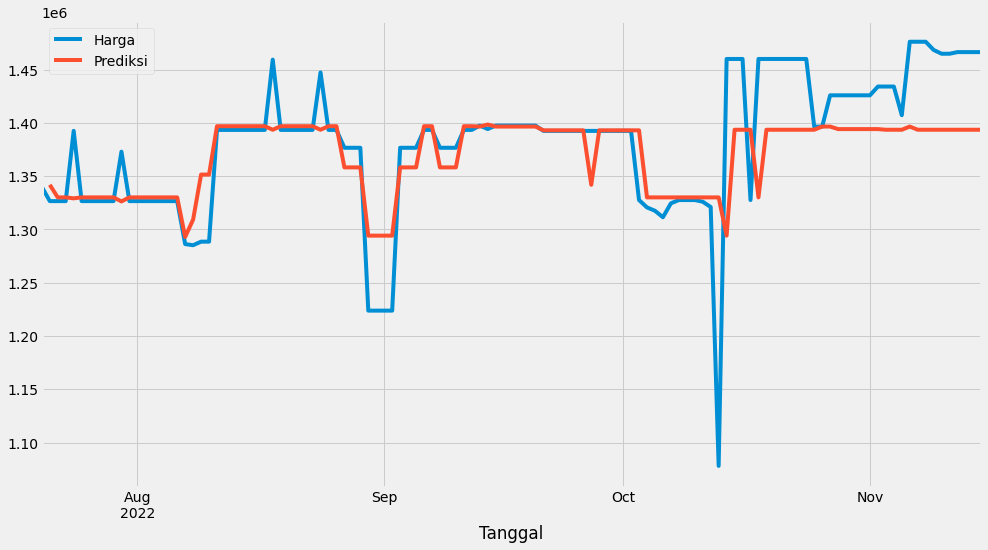

In [20]:
fig, ax = plt.subplots(figsize=(15,8))
df_dps_cgk2.plot(kind='line', ax=ax)
plt.show()

### Forecasting

In [21]:
X_test

,lag
Tanggal,
2022-09-27,NaN
2022-09-28,1392494.0
2022-09-29,1392494.0
2022-09-30,1392494.0
2022-10-01,1392494.0
2022-10-02,1392494.0
2022-10-03,1392494.0
2022-10-04,1327600.0
2022-10-05,1320704.0


In [22]:
from datetime import timedelta, datetime
def forecast(data, nlags, days_until_depart):
  t = datetime(2022, 11, 15)
  time_list = [t]
  hasil_forecast=[1466442] #pokonya ini ambil data X_test indeksnya [-n_lags:], bebas lo ambilnya gimanss
  days_until_depart=47     #hari sblom brangkat, kalo lstm 1 hari sebelum berangkat

  for i in range(days_until_depart):
    forecast_={'lag':hasil_forecast}
    apaiya_df = pd.DataFrame(forecast_, index=time_list)
    fr=reg.predict(apaiya_df)
    list(fr)
    hasil_forecast.append(fr[i])
    time = t + timedelta(days=1)
    t = time
    time_list.append(time)
  return apaiya_df

In [23]:
apaiya_df=forecast(X_test, 1, 47)

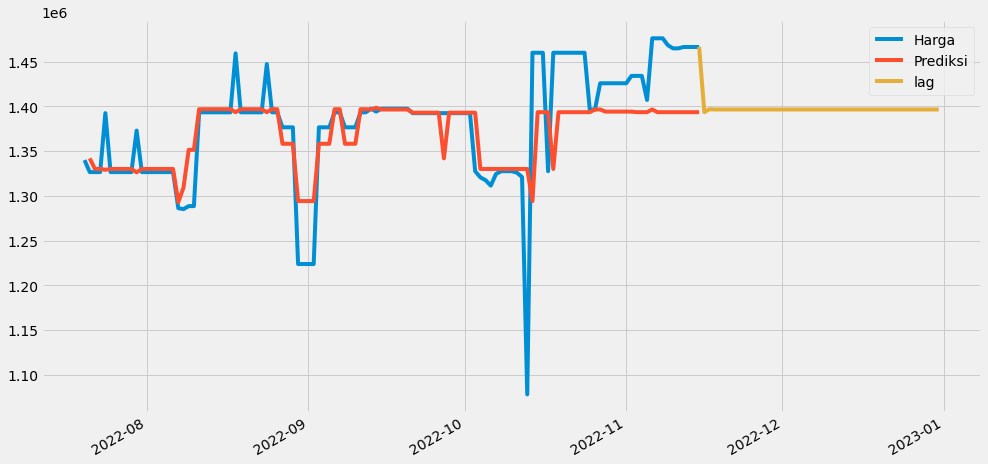

In [24]:
#Membuat plot 

from datetime import timedelta, datetime
df_dps_cgk3 = df_dps_cgk2.append(apaiya_df)
fig, ax = plt.subplots(figsize=(15,8))
df_dps_cgk3.plot(kind='line', ax=ax)
plt.show()

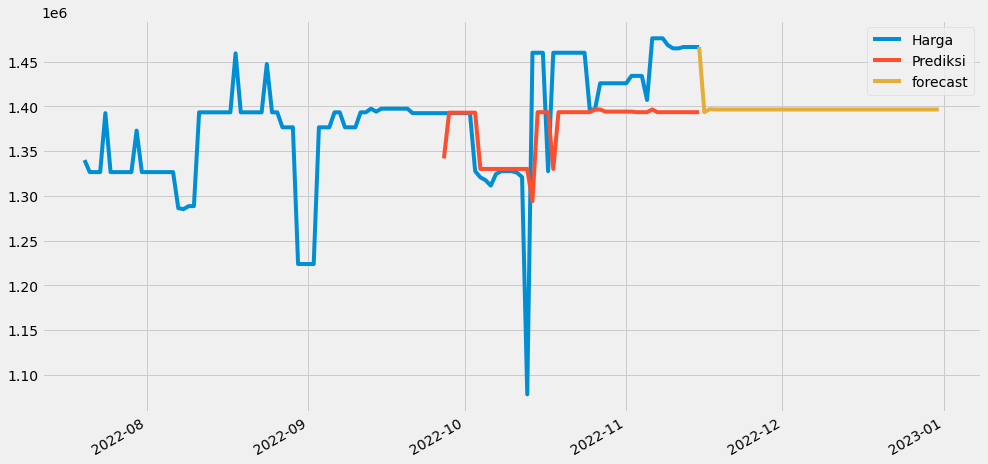

In [27]:
#Membuat plot 

from datetime import timedelta, datetime
df_dps_cgk4 = df_dps_cgk3
df_dps_cgk4. rename(columns = {'lag':'forecast'}, inplace = True)
df_dps_cgk4.iloc[1:-97, 1] = np.nan

fig, ax = plt.subplots(figsize=(15,8))
df_dps_cgk4.plot(kind='line', ax=ax)
plt.show()

# Koefisien Variansi

In [ ]:
df_dps_cgk.describe()

,Harga
count,1.190000e+02
mean,1.380685e+06
std,6.430353e+04
min,1.078150e+06
25%,1.327103e+06
50%,1.393419e+06
75%,1.425900e+06
max,1.476157e+06


In [ ]:
print('Koefisien Variansi DPS-CGK:',(np.sqrt(mean_squared_error(y_test,y_test_pred))/1.380685e+06)*100,'%')

Koefisien Variansi DPS-CGK: 4.837212222113641 %


In [ ]:
rmse=print(np.sqrt(mean_squared_error(y_test,y_test_pred)))

66786.66356888972
